In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod')

In [163]:
training_set = """

select adv.win_lose,
       adv.game_length,
       adv.ast_to_to,
       adv.ast_ratio,
       adv.defensive_reb_pct,
       adv.reb_pct,
       adv.to_pct,
       adv.ts_pct,
       adv.pace,
       fig.fta_rate,
       fig.tov_pct,
       fig.opp_tov_pct,
       fig.opp_off_reb_pct,
       score.pct_2pt_fg,
       score.pct_3pt_fg,
       score.pct_pts_ft,
       score.pct_pts_fbps,
       score.pct_pts_off_to,
       score.pct_pts_pitp,
       score.fgm_pct_ast,
       score.fgm_pct_uast,
       trad.fga,
       trad.3pa,
       trad.fta,
       trad.oreb,
       trad.dreb,
       trad.tot_reb,
       trad.ast,
       trad.stl,
       trad.blk,
       trad.personal_fouls,
       pts.diff,
       reb.off_reb,
       reb.def_reb,
       reb.tot_reb,
       t.own_to,
       t.opp_to,
       stand.home_loses,
       stand.home_wins,
       stand.away_loses,
       stand.away_wins,
       opp_pts.opp_pts as opp_pts_allowed,
       opp_pts.own_pts as opp_pts_scored
from box_scores_map_view as b
inner join(

         select b.game_hash,
                b.home_team,
                lu.season,
                h_team.team_id as home_id,
                a_team.team_id as away_id
         from box_score_map as b
                inner join game_date_lookup as lu on b.game_date = lu.day
                inner join team_info as h_team on b.home_team = h_team.team
                inner join team_info as a_team on b.away_team = a_team.team
         where b.game_date < current_date and
               lu.season > 2006

         ) as bm on ( (b.game_hash = bm.game_hash) and (b.team = bm.home_team) )

inner join team_advanced_boxscore_stats as adv on ( (bm.home_team = adv.team) and (bm.game_hash = adv.game_hash) )
inner join team_figure4_boxscore_stats as fig on ( (adv.team = fig.team) and (adv.game_hash = fig.game_hash) )
-- inner join team_misc_boxscore_stats as misc on ( (fig.team = misc.team) and (fig.game_hash = misc.game_hash) )
inner join team_scoring_boxscore_stats as score on ( (adv.team = score.team) and (adv.game_hash = score.game_hash) )
inner join team_traditional_boxscore_stats as trad on ( (score.team = trad.team) and (score.game_hash = trad.game_hash) )
inner join 3pt_pct as 3p on ( (bm.home_id = 3p.team_id) and (bm.season -1 = 3p.season) )
inner join points as pts on ( (bm.home_id = pts.team_id) and (bm.season -1 = pts.season) )
inner join rebound_pct as reb on ( (bm.home_id = reb.team_id) and (bm.season -1 = reb.season) )
inner join turnovers as t on ( (bm.home_id = t.team_id) and (bm.season -1 = t.season) )
inner join points as opp_pts on ( (bm.away_id = opp_pts.team_id) and (bm.season -1 = opp_pts.season) )
inner join team_standings as stand on ( (bm.home_team = stand.team) and (bm.season = stand.season) )

"""

In [164]:
train_df = pd.read_sql(sql=training_set, con=conn, index_col=None)

In [165]:
#test_df = pd.read_sql(sql=test_set, con=conn, index_col=None)

In [166]:
def get_dummies(col):
    return pd.get_dummies(col, drop_first=True)

In [167]:
results_train = get_dummies(train_df['win_lose'])

In [168]:
train_df = pd.concat([train_df, results_train], axis=1)

In [169]:
train_df.drop(['win_lose'], axis=1, inplace=True)

In [170]:
train_df.head()
#test_df.head()

,game_length,ast_to_to,ast_ratio,defensive_reb_pct,reb_pct,to_pct,ts_pct,pace,fta_rate,tov_pct,...,tot_reb,own_to,opp_to,home_loses,home_wins,away_loses,away_wins,opp_pts_allowed,opp_pts_scored,W
0,48,1.00,17.7,82.5,53.9,23.5,57.6,91.02,0.400,23.5,...,0.508,14.9,13.7,10,31,25,16,101.4,97.1,1
1,48,1.53,17.3,82.9,54.8,15.3,51.5,97.16,0.395,15.3,...,0.489,12.8,13.7,7,34,22,19,102.7,97.8,1
2,48,1.71,17.3,83.7,54.7,13.4,54.4,102.52,0.253,13.4,...,0.475,14.5,15.5,18,23,21,20,107.6,97.4,1
3,48,0.91,16.3,82.0,51.6,23.0,48.7,98.70,0.177,23.0,...,0.482,13.5,15.4,14,27,20,21,100.1,106.7,0
4,48,1.00,14.1,67.3,45.4,17.9,52.9,100.76,0.397,17.9,...,0.493,14.0,15.1,16,25,22,19,93.4,94.2,1


In [171]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('W', axis=1), train_df['W'], test_size=.33)

In [172]:
lg = LogisticRegression() #(penalty='l2', C=1.38383838)

In [173]:
lg.fit(X_train, y_train) #(train_df.drop('W', axis=1), train_df['W']) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
predictions = lg.predict(X_test)

In [175]:
lg.score(X_test, y_test)

0.9045918367346939

In [176]:
print(confusion_matrix(y_test, predictions))

[[1398  193]
 [ 181 2148]]


In [177]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.89      0.88      0.88      1591
          1       0.92      0.92      0.92      2329

avg / total       0.90      0.90      0.90      3920



In [178]:
pd.DataFrame(lg.coef_, columns=X_test.columns).T

,0
game_length,-0.632959
ast_to_to,0.050645
ast_ratio,-0.569107
defensive_reb_pct,-0.070402
reb_pct,0.235634
to_pct,-0.157596
ts_pct,0.589323
pace,-0.319648
fta_rate,-0.043056
tov_pct,-0.157596


In [179]:
#lg.fit(train_df.drop('W', axis=1), train_df['W'] )

In [139]:
#predictions = lg.predict(test_df.drop('W', axis=1))

In [140]:
#print(confusion_matrix(test_df['W'], predictions))

In [141]:
#print(classification_report(test_df['W'], predictions))

In [142]:
#sns.pairplot(test_df)

In [143]:
#print(lg.coef_)

In [144]:
#col = train_df.drop('W', axis=1)
#col.columns

In [145]:
#pd.DataFrame(lg.coef_, columns=train_df.drop('W', axis=1).columns).T

In [146]:
#list(np.concatenate([np.power(10.0, np.arange(1, 15)), np.linspace(1, 9.99, 50)]))

In [180]:
#test_c_vals = np.linspace(5, 25, 40) # np.concatenate([np.power(10.0, np.arange(1, 15)), np.linspace(1, 9.99, 50)])
test_c_vals = list(np.power(10.0, np.arange(0, 10)))
test_c_vals

[1.0,
 10.0,
 100.0,
 1000.0,
 10000.0,
 100000.0,
 1000000.0,
 10000000.0,
 100000000.0,
 1000000000.0]

In [181]:
score = np.empty_like(test_c_vals)

In [182]:
for c, i in enumerate(test_c_vals):
    lg = LogisticRegression(penalty='l2', C=i)
    lg.fit(X_train, y_train)
    score[c] = lg.score(X_test, y_test)
score

array([ 0.90459184,  0.90408163,  0.90433673,  0.90459184,  0.90459184,
        0.90408163,  0.90408163,  0.90408163,  0.90331633,  0.90459184])

In [183]:
folds = KFold(n_splits=5, shuffle=True)

log_reg_cv = LogisticRegressionCV(Cs=test_c_vals, 
                                  cv=folds, 
                                  penalty="l2", 
                                  scoring='roc_auc', 
                                  solver='newton-cg', 
                                  max_iter=10000)

log_reg_cv.fit(train_df.drop('W', axis=1), train_df['W'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)


LogisticRegressionCV(Cs=[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None,
           cv=KFold(n_splits=5, random_state=None, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=10000, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='newton-cg', tol=0.0001, verbose=0)

In [184]:
cv_score = log_reg_cv.score(train_df.drop('W', axis=1), train_df['W'])

In [185]:
cv_c = log_reg_cv.C_

In [186]:
cv_c, cv_score

(array([ 1.]), 0.90485011788480973)

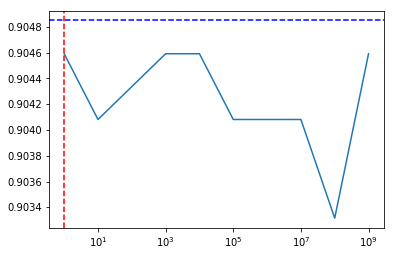

In [187]:
plt.plot(test_c_vals, score)
ax = plt.gca()
ax.set_xscale('log')
plt.axhline(cv_score, color='b',ls='--')
plt.axvline(cv_c, color='r', ls='--')

In [188]:
np.take(test_c_vals, np.argmax(score))

1.0

In [189]:
np.amax(score)

0.9045918367346939

#score
2005 -- LCV 0.90494697319017192
2006 -- L 0.90989437378745419 **
2007 -- L 0.90860089055542537
2008 -- LCV 0.90485011788480973

In [197]:
t = [['Atlanta', 'Brooklyn']]
df = pd.DataFrame(t, columns=['away', 'home'])

In [198]:
df


,away,home
0,Atlanta,Brooklyn
